<img style="float: left;" src="resources/made.jpg" width="35%" height="35%">

# Академия MADE
## Семинар 8 часть 1. Трекинг: фильтр Калмана
Иван Карпухин, ведущий программист-исследователь команды машинного зрения

<div style="clear:both;"></div>

В этой части семинара применим фильтр Калмана к предсказанию перемещения людей.

Мы воспользуемся готовой реализацией фильтра. В рамках семинара предлагается настроить парметры фильтра и применить его.

Для выполнения работы нужны следующие пакеты (Python 3):
* filterpy
* matplotlib
* numpy
* opencv-python
* pyyaml

Установить их можно командой:
```bash
pip3 install --user filterpy matplotlib numpy opencv-python pyyaml
```

In [1]:
# Раскомментируйте строчку ниже, чтобы установить зависимости.
#!pip3 install --user filterpy matplotlib numpy opencv-python pyyaml

In [2]:
from IPython.display import Video

import numpy as np
from matplotlib import pyplot as plt

import check
import seminar

# Исходное видео.
VIDEO_PATH = "data/sample.mp4"

# Видео с обнаруженными лицами.
DEMO_PATH = "data/sample-demo.mp4"

# Результаты работы детектора.
DETECTIONS_PATH = "data/sample-tracks.yaml"

# Входные данные для трекера

К нам поступил [видеофайл](https://www.youtube.com/watch?v=SvldnZ6qMGU) с записью людей на проходе в торговом центре. У нас имеется детектор лиц. Мы применили детектор лиц к видеофайлу и для каждого кадра получили набор описывающих прямоугольников (bounding box, BBox):

<img align="left" src="resources/video-frame.jpg" width="80%" height="80%">
<div style="clear:both;"></div>

На видео ниже полные результат работы детектора:

In [3]:
Video(DEMO_PATH, width=400)

Результаты работы детектора лиц хранятся в списке detections. Его длина соответствует числу кадров в видео (немного короче, т.к. в конце видео не нашлось детектов). Каждый элемент detections содержит список прямоуголников для кадра видео. Каждый прямоугольник задаётся четвёркой чисел: \[left, top, width, height\], или сокращённо \[l, t, w, h\].

In [4]:
FRAME_WIDTH, FRAME_HEIGHT, NUM_FRAMES, FRAME_RATE = seminar.video_probe(VIDEO_PATH)
print("Размер кадра: {}x{}".format(FRAME_WIDTH, FRAME_HEIGHT))
print("Число кадров:", NUM_FRAMES)
print("Частота кадров:", FRAME_RATE)

detections, _, _ = seminar.read_data(DETECTIONS_PATH)
print()
print("Общее число детектов:", sum(map(len, detections)))
print("Лица на 1-м кадре:", detections[0])
print("Лица на 60-м кадре:", detections[59])

Размер кадра: 960x720
Число кадров: 119
Частота кадров: 6.0

Общее число детектов: 393
Лица на 1-м кадре: [[228, 363, 61, 75]]
Лица на 60-м кадре: [[139, 601, 80, 109], [542, 134, 49, 58], [460, 99, 47, 63]]


ЗАДАНИЕ: Какая высота у 2-го прямоугольника на 16-м кадре?

In [5]:
height_16_2 = detections[15][1][3]  # Ваш код.

assert check.check_height_16_2(height_16_2, detections)

Результат: отлично!


# Фильтр Калмана

Мы хотим сгруппировать прямоугольники с разных кадров для каждого человека. На изображении ниже X и Y это координаты пикселя, а T - время. Разными цветами помечены прямоугольники разных лиц.

<img align="left" src="resources/tracking.jpg" width="35%" height="35%">
<div style="clear:both;"></div>

Выполнять группировку мы будем последовательно: кадр за кадром. Связывать прямоугольники на соседних кадрах будем в два шага:

1. предскажем куда может переместиться прямоугольник за один кадр,
2. из обнаруженных на следующем кадре прямоугольников найдём ближайший к предсказанному.

<img align="left" src="resources/prediction.jpg" width="35%" height="35%">
<div style="clear:both;"></div>

В этой части семинара реализуем только шаг предсказания.

В алгоритме [Simple online and realtime tracking (SORT)](https://arxiv.org/pdf/1602.00763.pdf]) задача предсказания решается с использованием фильтра Калмана.

Чтобы применить фильтр, нужно определить динамический процесс. Состояние каждого прямоугольника в каждый момент времени будем описывать вектором \[x, y, s, r, x', y', s'\], где:
* x: X координата центра прямоугольника
* y: Y координата центра прямоугольника
* s: Масштаб, среднее арифметическое ширины и высоты: 0.5 * (width + height)
* r: Отношение ширины и высоты: width / height
* x': Скорость изменения X
* y': Скорость изменения Y
* s': Скорость изменения масштаба

Параметр r считается постоянным и для него нет скорости изменения.

Фильтр Калмана позволяет по новому наблюдению оптимально обновить состояние. Поскольку состояние содержит положение и скорость, мы сможем по состоянию предсказать следующий прямоугольник.

ЗАДАНИЕ. В фильтре используется формат прямоугольников \[x, y, s, r\], отличный от исходного \[l, t, w, h\]. Предлагается реализовать преобразование формата в функции ниже.

In [6]:
def ltwh2xysr(ltwh):
    """Преобразовать формат прямоугольника из [l, t, w, h] в [x, y, s, r].
    
    Вход может содержать вещественные числа. Выход не нужо округлять до целых.
    
    На входе и на выходе могут быть и списки и массивы Numpy.
    
    Вход: прямоугольник в формате [l, t, w, h].
    Выход: прямоугольник в формате [x, y, s, r].
    """
    return [
        ltwh[0] + ltwh[2] / 2,
        ltwh[1] + ltwh[3] / 2,
        (ltwh[2] + ltwh[3]) / 2,
        ltwh[2] / ltwh[3]
    ]


assert check.check_ltwh2xysr(ltwh2xysr)

Результат: отлично!


Аналогично введём обратное преобразование

In [7]:
def xysr2ltwh(xysr):
    """Преобразовать формат прямоугольника из [x, y, s, r] в [l, t, w, h].
    
    На входе и на выходе могут быть и списки и массивы Numpy.
    
    Вход может содержать вещественные числа. Выход не нужо округлять до целых.
    
    Вход: прямоугольник в формате [x, y, s, r].
    Выход: прямоугольник в формате [l, t, w, h].
    """
    h = 2 * xysr[2] / (xysr[3] + 1)
    w = xysr[3] * h
    return [
        xysr[0] - w / 2,
        xysr[1] - h / 2,
        w,
        h
    ]

Фильтр Калмана применяется к процессам вида:

$State_k = F State_{k-1} + B u_k + w_k$

Обозначения:

$State_k$ - состояние \[x, y, s, r, x', y', s'\] в момент времени k.

$F$ - матрица эволюции системы, которая по предыдущему состоянию позволяет предсказать следующее.

$B$ - матрица управляющего воздействие (нулевая матрица, т.к. мы только наблюдаем).

$u_k$ - управляющее воздействие (нулевой вектор, т.к. мы только наблюдаем).

$w_k$ - ошибка предсказания модели: случайный вектор с распределением $\mathcal{N}(0, Q)$, где $Q$ - ковариационная матрица.

<br>

Поскольку $B$ и $u_k$ в нашем случае равны нулю, получаем:

$State_k = F State_{k-1}  + w_k$

<br>

Мы умеем предсказывать следующее состояние, но также умеем наблюдать реальные исходы $z_k$:

$z_k = H_k x_k + v_k$

Здесь $H_k$ - матрица, которая преобразует состояние в наблюдение. На каждом кадре мы наблюдаем только прямоугольник. Скорость считается скрытым параметром. Т.е. вектор $z_k$ задаётся четвёркой \[x, y, s, r\], а умножение на матрицу $H_k$ должно из состояния извлеч все числа кроме скорости: \[x, y, s, r, x', y', s'\] -> \[x, y, s, r\].

Наблюдения неточные, они имеют ошибку $v_k$ - вектор, распределеный нормально $\mathcal{N}(0, R)$ с матрицей ковариации R.

Подробнее на [Wikipedia](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D0%BB%D1%8C%D1%82%D1%80_%D0%9A%D0%B0%D0%BB%D0%BC%D0%B0%D0%BD%D0%B0)

ЗАДАНИЕ. Предлагается заполнить матрицы F, Q, H, R.

Полезные функции:

```python
np.diag(a):
    """По вектору строит диагональную матрицу."""
    
np.eye((x, y)):
    """Возвращает прямоугольную матрицу с 1 на диагонали. Остальные элементы равны 0."""
```

In [8]:
def get_F():
    """Возвращает матрицу F.
    
    F - матрица обновления состояния: State_k = F State_{k-1} + w_k.
    
    На выходе может быть и список списков и массив Numpy.
    """
    return [
        [1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1]
    ]


assert check.check_get_F(get_F)

Результат: отлично!


In [9]:
def get_Q(pos_std=1, scale_std=1, aspect_std=1,
          pos_velocity_std=0.1, scale_velocity_std=0.01):
    """Возвращает матрицу Q.
    
    Q - ковариационная матрица ошибки модели w_k.
    
    На выходе может быть и список списков и массив Numpy.
    
    Вход:
    1. pos_std, scale_std, aspert_std - стандартные отклонения ошибок (x, y), s, и r.
    2. pos_velocity_std, scale_velocity_std - стандартные отклонения ошибок скоростей (x, y) и s.
    
    Выход: матрица Q.
    """
    return np.diag([pos_std, pos_std, scale_std, aspect_std, pos_velocity_std, pos_velocity_std, scale_velocity_std]) ** 2


assert check.check_get_Q(get_Q)

Результат: отлично!


In [10]:
def get_H():
    """Возвращает матрицу H.
    
    H - матрица отображения состояния в наблюдение: H [x, y, s, r, x', y', s'] -> [x, y, s, r].
    
    На выходе может быть и список списков и массив Numpy.
    """
    return [
        [1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0]
    ]


assert check.check_get_H(get_H)

Результат: отлично!


In [11]:
def get_R(pos_std=0.1, scale_std=3, aspect_std=3):
    """Возвращает матрицу R.
    
    R - ковариационная матрица ошибки наблюдения v_k.
    
    На выходе может быть и список списков и массив Numpy.
    """
    return np.diag([pos_std, pos_std, scale_std, aspect_std]) ** 2


assert check.check_get_R(get_R)

Результат: отлично!


Начальное состояние фильтра мы инициализируем первым наблюдаемым прямоугольником, и только потом начинаем прдесазывать следующие прямоугольники. Наблюдение содержит в себе шум и совпадает с истинным состоянием лишь приблизительно. Для работы фильтра нужно определить матрицу ковариаций начального состояния.

ЗАДАНИЕ. Предлагается определить начальную ковариационную матрицу $P$ состояния системы. Она задаёт неопределённость состояния в начальный момент времени.

In [12]:
def get_P(pos_std=3, scale_std=3, aspect_std=3,
          pos_velocity_std=100, scale_velocity_std=100):
    """Возвращает матрицу P.
    
    P - ковариационная матрица начального состояния фильтра.
    
    Вход:
    1. pos_std, scale_std, aspert_std - стандартные отклонения ошибок (x, y), s, и r.
    2. pos_velocity_std, scale_velocity_std - стандартные отклонения ошибок скоростей (x, y) и s.
    
    Выход: матрица P.
    """
    return np.diag([pos_std, pos_std, scale_std, aspect_std, pos_velocity_std, pos_velocity_std, scale_velocity_std]) ** 2


assert check.check_get_P(get_P)

Результат: отлично!


# Применение фильтра (писать код не нужно)

Протестируем фильтр на примере последовательности лиц одного человека.

В качестве реализации фильтра Калмана мы используем библиотеку filterpy. Нам потребуется класс KalmanFilter и следующие его методы:

```python
KalmanFilter.__init__(self, dim_x, dim_z):
    """Создать новый фильтр.
    
    dim_x - размер состояния
    dim_z - размер наблюдения
    """
    
KalmanFilter.predict(self):
    """Предсказать следующее состояние. Новое состояние сохраняется в фильтре."""
    
KalmanFilter.update(self, z):
    """Обновить состояние фильтра используя новое наблюдение z и сохранённое ранее предсказание."""
```

Если f - фильтр, то получить текущее состояние можно так:
```python
f.x
```

Можно преобразовать состояние \[x, y, s, r, x', y', s'\] в наблюдение \[x, y, s, r\]:
```python
f.measurement_of_state(filter.x)
```

Параметры фильтра задаются через присваивание атрибутов
```python
f.F = ...
f.Q = ...
...
```

Применение фильтра состоит в поочерёдном вызове методов predict и update.

In [13]:
from filterpy.kalman import KalmanFilter


def create_kalman_filter(initial_state=None):
    f = KalmanFilter(dim_x=7, dim_z=4)
    
    if initial_state is not None:
        f.x = np.asarray(initial_state)

    f.F = np.asarray(get_F())
    f.Q = np.asarray(get_Q())
    f.H = np.asarray(get_H())
    f.R = np.asarray(get_R())
    f.P = np.asarray(get_P())
    
    return f

In [14]:
def predict(bboxes_xysr):
    """В каждый момент времени предсказать следующий прямоугольник используя все предыдущие.
    
    Вход:
    1. filter: Фильтр Калмана.
    2. bboxes_xysr: Список прямоугольников одного человека.
                    Часть элементов может быть None, если на кадре лицо не нашлось.
                    
    Выход:
    1. Список предсказанных прямоугольников той же длины, что и bboxes_xysr.
    2. Финальное состояние фильтра.
    """
    
    # Инициализируем фильтр для нового прогона используя первый прямоугольник.
    # Скорости изначально выставляем в 0.
    assert bboxes_xysr[0] is not None
    filter = create_kalman_filter(
        initial_state=list(bboxes_xysr[0]) + [0, 0, 0]
    )
    
    predictions = []
    for bbox in bboxes_xysr:
        # Шаг 1: предсказываем следующее состояние.
        filter.predict()
        
        # Сохраняем предсказанное значение.
        predictions.append(filter.measurement_of_state(filter.x))
        
        # Шаг2. Скорректируем состояние, если на данном кадре есть лицо человека.
        # Если лица нет, то следующий predict продолжит процесс без изменения скоростей.
        if bbox is not None:
            filter.update(bbox)
    return predictions, filter.x

# Загрузим пример цепочки прямоугольников в формате [l, t, w, h].
bboxes = seminar.load_track_detections(DETECTIONS_PATH, 6)
print("Число кадров в треке:", len(bboxes))

# Конвертируем в формат [x, y, s, r] для фильтра.
bboxes_xysr = [(ltwh2xysr(bbox) if bbox is not None else None)
               for bbox in bboxes]

# В каждый момент времени предскажем следующий прямоугольник используя все предыдущие.
predictions_xysr, final_state = predict(bboxes_xysr)

print("Финальное состояние фильтра:\n{}".format(final_state))

Число кадров в треке: 43
Финальное состояние фильтра:
[8.29836635e+02 6.78587038e+02 5.62906633e+01 8.46260687e-01
 1.81654967e+01 1.36055704e+01 5.99395214e-01]


ВОПРОС. В модель заложено, что скорость не изменяется. Почему скорость в начальном состоянии 0, а в конечном не 0?

Серые прямоугольники - реальные детекты лиц из видео
Красные прямоугольники - предсказанные фильтром по истории наблюдений
Насыщенность цвета отражает течение времени


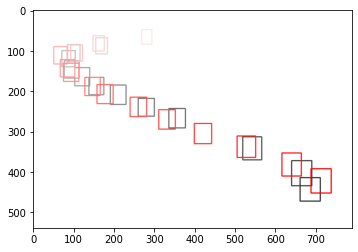

In [15]:
print("Серые прямоугольники - реальные детекты лиц из видео")
print("Красные прямоугольники - предсказанные фильтром по истории наблюдений")
print("Насыщенность цвета отражает течение времени")
# Для наглядности выводим каждый третий кадр.
plt.imshow(seminar.render_bboxes(bboxes_xysr[2::3], predictions_xysr[2::3], is_xysr=True))
plt.show()

Обратите внимание на отдельно стоящий красный прямоугольник в центре. На этом кадре лицо не нашлось, наблюдения нет. Есть только предсказание, которое неплохо интерполирует между соседними кадрами.

# Другие примеры фильтрации (писать код не нужно)

### Синусоида

Серые прямоугольники - реальные детекты лиц из видео
Красные прямоугольники - предсказанные фильтром по истории наблюдений
Насыщенность цвета отражает течение времени


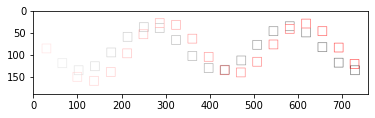

In [16]:
def generate_sin_boxes():
    bboxes = []
    for x in np.linspace(0, 14, 20):
        bboxes.append([50 * x, 50 * np.sin(x), 20, 20])
    return bboxes

bboxes = generate_sin_boxes()
bboxes_xysr = [(ltwh2xysr(bbox) if bbox is not None else None)
               for bbox in bboxes]
predictions_xysr, _ = predict(bboxes_xysr)

print("Серые прямоугольники - реальные детекты лиц из видео")
print("Красные прямоугольники - предсказанные фильтром по истории наблюдений")
print("Насыщенность цвета отражает течение времени")
plt.imshow(seminar.render_bboxes(bboxes_xysr, predictions_xysr, is_xysr=True))
plt.show()

### Масштаб

Серые прямоугольники - реальные детекты лиц из видео
Красные прямоугольники - предсказанные фильтром по истории наблюдений
Насыщенность цвета отражает течение времени


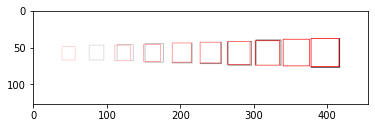

In [17]:
def generate_scale_boxes():
    bboxes = []
    for x in np.linspace(0, 7, 10):
        s = 3 * (x + 6)
        bboxes.append([50 * x - s / 2, - s / 2, s, s])
    return bboxes

bboxes = generate_scale_boxes()
bboxes_xysr = [(ltwh2xysr(bbox) if bbox is not None else None)
               for bbox in bboxes]
predictions_xysr, _ = predict(bboxes_xysr)

print("Серые прямоугольники - реальные детекты лиц из видео")
print("Красные прямоугольники - предсказанные фильтром по истории наблюдений")
print("Насыщенность цвета отражает течение времени")
plt.imshow(seminar.render_bboxes(bboxes_xysr, predictions_xysr, is_xysr=True))
plt.show()

Фильтр хорошо оценивает линейный рост размера прямоугольника: предсказанные красные прямоугольники почти совпадают с наблюдаемыми серыми.

# Ссылки

## Фильтр Калмана

https://habr.com/ru/post/166693/

https://en.wikipedia.org/wiki/Kalman_filter

## Статьи

SORT: https://arxiv.org/abs/1602.00763

DeepSORT: https://arxiv.org/abs/1703.07402

## Реализации

Kalman: https://filterpy.readthedocs.io/en/latest/kalman/KalmanFilter.html

SORT: https://github.com/abewley/sort

DeepSORT: https://github.com/nwojke/deep_sort